## Projeto para competição de Kaggle 

# Import's

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler,RobustScaler
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

# Preparar a informação

In [114]:
df = pd.read_csv("C:\\Users\\catar\\Desktop\\Projetos AI\\ML_houseprices\\train.csv")

In [115]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Eliminar Variáveis desnecessárias

In [117]:
df = df.drop(columns=['Id','Utilities','GarageYrBlt'])

In [118]:
linear_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
ordinal_categorical_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'E

# Análise das variáveis mais importante e Outlier selection

GrLivArea

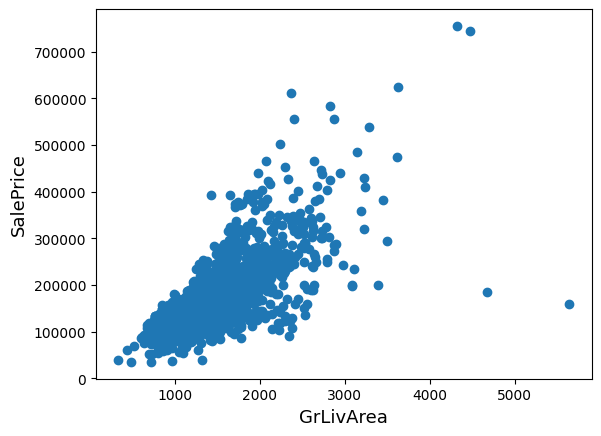

In [119]:
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

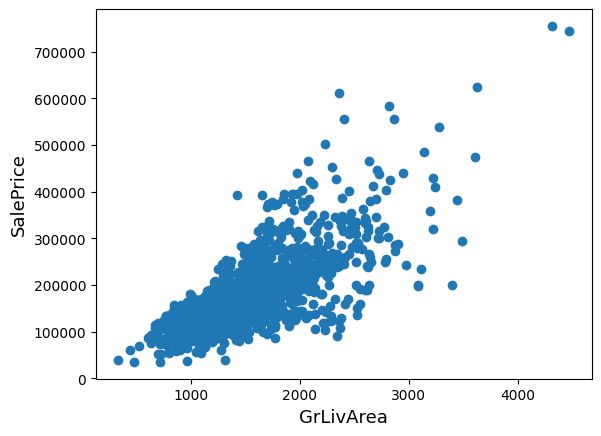

In [120]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
df = df.reset_index(drop=True)
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

OverallQual

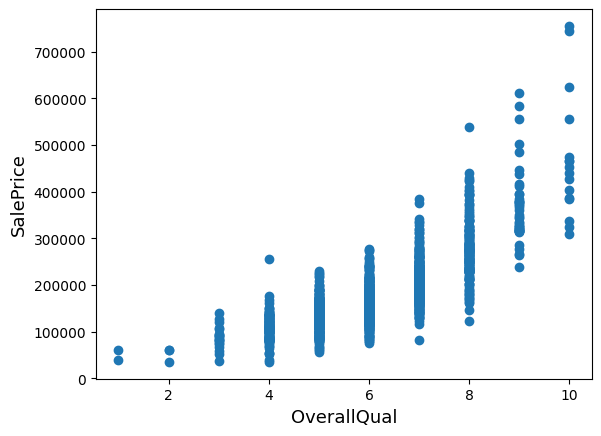

In [121]:
fig, ax = plt.subplots()
ax.scatter(x = df['OverallQual'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

Neighborhood

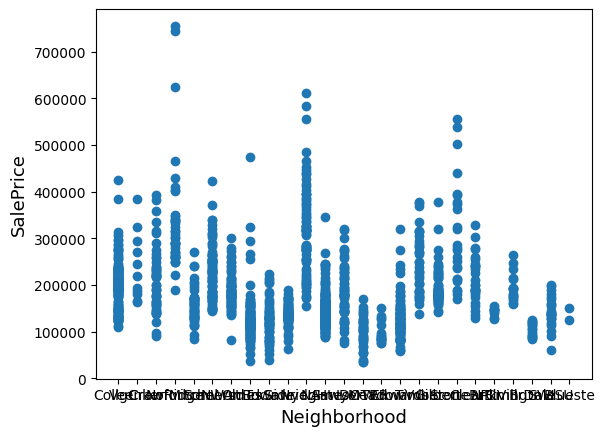

In [122]:
fig, ax = plt.subplots()
ax.scatter(x = df['Neighborhood'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Neighborhood', fontsize=13)
plt.show()

# Distribuição dos preços e transformação da target variable

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Figure size 600x500 with 0 Axes>

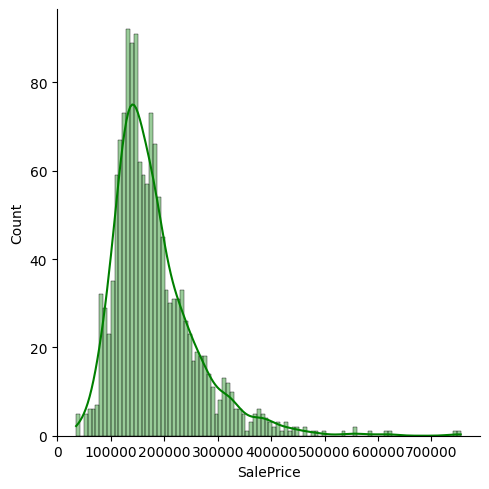

In [123]:
print(df['SalePrice'].describe())
plt.figure(figsize=(6, 5))
sn.displot(df['SalePrice'], color='g', bins=100, alpha=0.4, kde=True);

count    1458.000000
mean       12.024015
std         0.399713
min        10.460271
25%        11.774720
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64


<Figure size 600x500 with 0 Axes>

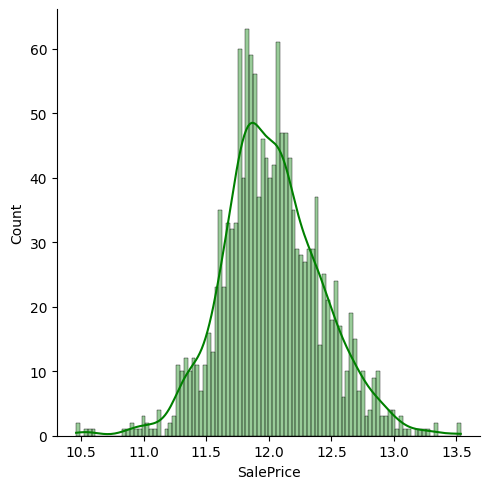

In [124]:
#Os preços estão muito right-skewed e como os modelos comportam-se melhores com data normalmente distribuida vamos aplicar log-transform
df['SalePrice']= np.log1p(df['SalePrice'])
print(df['SalePrice'].describe())
plt.figure(figsize=(6, 5))
sn.displot(df['SalePrice'], color='g', bins=100, alpha=0.4, kde=True);

# Feature Engineering

Lidar com Nulls e fazer Encoding

In [125]:
#Ordinal Encoding: Street,Alley,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual
#                  BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual
#                  Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC
#                  Fence

columns_to_encode = ['Street', 'Alley', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

categories_list = [['Grvl', 'Pave'],
                   ['Grvl', 'Pave'],
                   ['IR3', 'IR2', 'IR1', 'Reg'],
                   ['Sev', 'Mod', 'Gtl'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['No', 'Mn', 'Av', 'Gd'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Unf', 'RFn', 'Fin'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'P', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

ordinal_encoder = OrdinalEncoder(categories= categories_list,
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1,
                                 dtype=np.int64)
#Converter para objeto para garantir compatabilidade
df[columns_to_encode] = df[columns_to_encode].astype(object)
df[columns_to_encode] = ordinal_encoder.fit_transform(df[columns_to_encode])
df


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,1,-1,3,Lvl,Inside,2,...,0,-1,-1,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,1,-1,3,Lvl,FR2,2,...,0,-1,-1,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,1,-1,2,Lvl,Inside,2,...,0,-1,-1,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,1,-1,2,Lvl,Corner,2,...,0,-1,-1,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,1,-1,2,Lvl,FR2,2,...,0,-1,-1,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,60,RL,62.0,7917,1,-1,3,Lvl,Inside,2,...,0,-1,-1,NaN,0,8,2007,WD,Normal,12.072547
1454,20,RL,85.0,13175,1,-1,3,Lvl,Inside,2,...,0,-1,2,NaN,0,2,2010,WD,Normal,12.254868
1455,70,RL,66.0,9042,1,-1,3,Lvl,Inside,2,...,0,-1,3,Shed,2500,5,2010,WD,Normal,12.493133
1456,20,RL,68.0,9717,1,-1,3,Lvl,Inside,2,...,0,-1,-1,NaN,0,4,2010,WD,Normal,11.864469


In [126]:
#Target Encoding: MSZoning, LandContour,LotConfig,Neighborhood,Condition1,Condition2,
#                 BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,
#                 MasVnrType,Foundation,Heating,Electrical,GarageType,MiscFeature,SaleType,SaleCondition

columns_to_encode = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
           'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
           'SaleType', 'SaleCondition']

kf = KFold(n_splits=3,shuffle=True, random_state=42)
medias_groupby_col = []
for col in columns_to_encode:
    df[col] = df[col].fillna('Missing')
    global_mean = df.groupby(col)['SalePrice'].mean()
    medias_groupby_col.append(global_mean)
    for data_mean, values_to_fix in kf.split(df):
        data_mean_df, values_to_fix_df = df.iloc[data_mean], df.iloc[values_to_fix]
        target_mean = data_mean_df.groupby(col)['SalePrice'].mean()
        
        #mapeia usando target value mas caso não seja possivel, por falta de casos mapeia com a média global
        mapped_values = values_to_fix_df[col].map(target_mean)
        global_mapped_values = values_to_fix_df[col].map(global_mean)
        filled_values = mapped_values.fillna(global_mapped_values)

        df.loc[values_to_fix, col] = filled_values
    df[col] = df[col].astype(np.float64)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   float64
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   int64  
 5   Alley          1458 non-null   int64  
 6   LotShape       1458 non-null   int64  
 7   LandContour    1458 non-null   float64
 8   LotConfig      1458 non-null   float64
 9   LandSlope      1458 non-null   int64  
 10  Neighborhood   1458 non-null   float64
 11  Condition1     1458 non-null   float64
 12  Condition2     1458 non-null   float64
 13  BldgType       1458 non-null   float64
 14  HouseStyle     1458 non-null   float64
 15  OverallQual    1458 non-null   int64  
 16  OverallCond    1458 non-null   int64  
 17  YearBuilt      1458 non-null   int64  
 18  YearRemo

Finalizar detalhes

In [127]:
#Substituir pela média do bairro
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#Esta coluna tem praticamente 0 variação e não irá contribuir muito para o modelo / Alta correlação com ano de construção e dificil lidar com Nulls
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1449 entries, 0 to 1457
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1449 non-null   int64  
 1   MSZoning       1449 non-null   float64
 2   LotFrontage    1449 non-null   float64
 3   LotArea        1449 non-null   int64  
 4   Street         1449 non-null   int64  
 5   Alley          1449 non-null   int64  
 6   LotShape       1449 non-null   int64  
 7   LandContour    1449 non-null   float64
 8   LotConfig      1449 non-null   float64
 9   LandSlope      1449 non-null   int64  
 10  Neighborhood   1449 non-null   float64
 11  Condition1     1449 non-null   float64
 12  Condition2     1449 non-null   float64
 13  BldgType       1449 non-null   float64
 14  HouseStyle     1449 non-null   float64
 15  OverallQual    1449 non-null   int64  
 16  OverallCond    1449 non-null   int64  
 17  YearBuilt      1449 non-null   int64  
 18  YearRemodAdd 

c:\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [128]:
#Criação de uma feature potencialmente importante

df['TotalArea']= df['TotalBsmtSF']+ df['1stFlrSF'] + df['2ndFlrSF']
df.insert(2, 'TotalArea', df.pop('TotalArea'))

C:\Users\catar\AppData\Local\Temp\ipykernel_15640\2320538360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalArea']= df['TotalBsmtSF']+ df['1stFlrSF'] + df['2ndFlrSF']


Skew das variáveis e transformação de highly-skewed

In [129]:
skewness = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_feature = pd.DataFrame({'Skew' :skewness})
skew_feature_transform = skewness_feature[abs(skewness_feature['Skew']) > 1].index
print(skewness_feature[abs(skewness_feature['Skew']) > 1])

lamb = 0.1 #Pode ser otimizado
for feature in skew_feature_transform:
   df[feature] = boxcox1p(df[feature],lamb)

skewness = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_feature = pd.DataFrame({'Skew' :skewness})
print(skewness_feature[abs(skewness_feature['Skew']) > 1])

                    Skew
MiscVal        24.359502
PoolQC         17.480663
PoolArea       15.882700
RoofMatl       12.995152
LotArea        12.597274
3SsnPorch      10.253854
LowQualFinSF    8.966866
KitchenAbvGr    4.504598
Alley           4.300574
BsmtFinSF2      4.250357
ScreenPorch     4.099864
BsmtHalfBath    4.081053
BsmtFinType2    3.290124
EnclosedPorch   3.088074
LotConfig       3.044522
MasVnrArea      2.683933
OpenPorchSF     2.366521
SaleCondition   2.050328
Condition2      1.967491
Fence           1.793122
WoodDeckSF      1.546247
LotFrontage     1.539161
SaleType        1.515206
MSSubClass      1.406188
ExterCond       1.386111
RoofStyle       1.277050
BsmtExposure    1.103465
MasVnrType      1.022698
GrLivArea       1.015661
LandContour    -1.090665
LotShape       -1.286153
BsmtQual       -1.290358
Condition1     -1.801955
MSZoning       -1.941387
BldgType       -2.897782
Electrical     -3.111722
GarageQual     -3.209793
PavedDrive     -3.289819
GarageCond     -3.312692


C:\Users\catar\AppData\Local\Temp\ipykernel_15640\2154644894.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = boxcox1p(df[feature],lamb)


                    Skew
PoolQC         15.477951
PoolArea       15.461376
RoofMatl       12.843654
3SsnPorch       7.757444
LowQualFinSF    7.509759
MiscVal         5.326502
KitchenAbvGr    3.966888
BsmtHalfBath    3.920872
Alley           3.636468
ScreenPorch     3.154268
LotConfig       3.040884
BsmtFinSF2      2.578814
EnclosedPorch   2.137158
SaleCondition   2.004711
Fence           1.552320
SaleType        1.396430
RoofStyle       1.269414
Condition2      1.194805
MasVnrType      1.006487
LandContour    -1.174079
Condition1     -1.832950
MSZoning       -1.972174
LotShape       -2.282502
BldgType       -2.901262
Electrical     -3.125260
PavedDrive     -3.400969
CentralAir     -3.510384
GarageCond     -3.854669
GarageQual     -3.855773
BsmtExposure   -4.983264
BsmtFinType2   -5.315343
LandSlope      -5.696448
MiscFeature    -5.784984
Functional     -5.823834
BsmtQual       -5.881143
BsmtCond       -5.977647
Heating       -11.013086
Street        -15.443580


# Análise de variáveis

Correlações

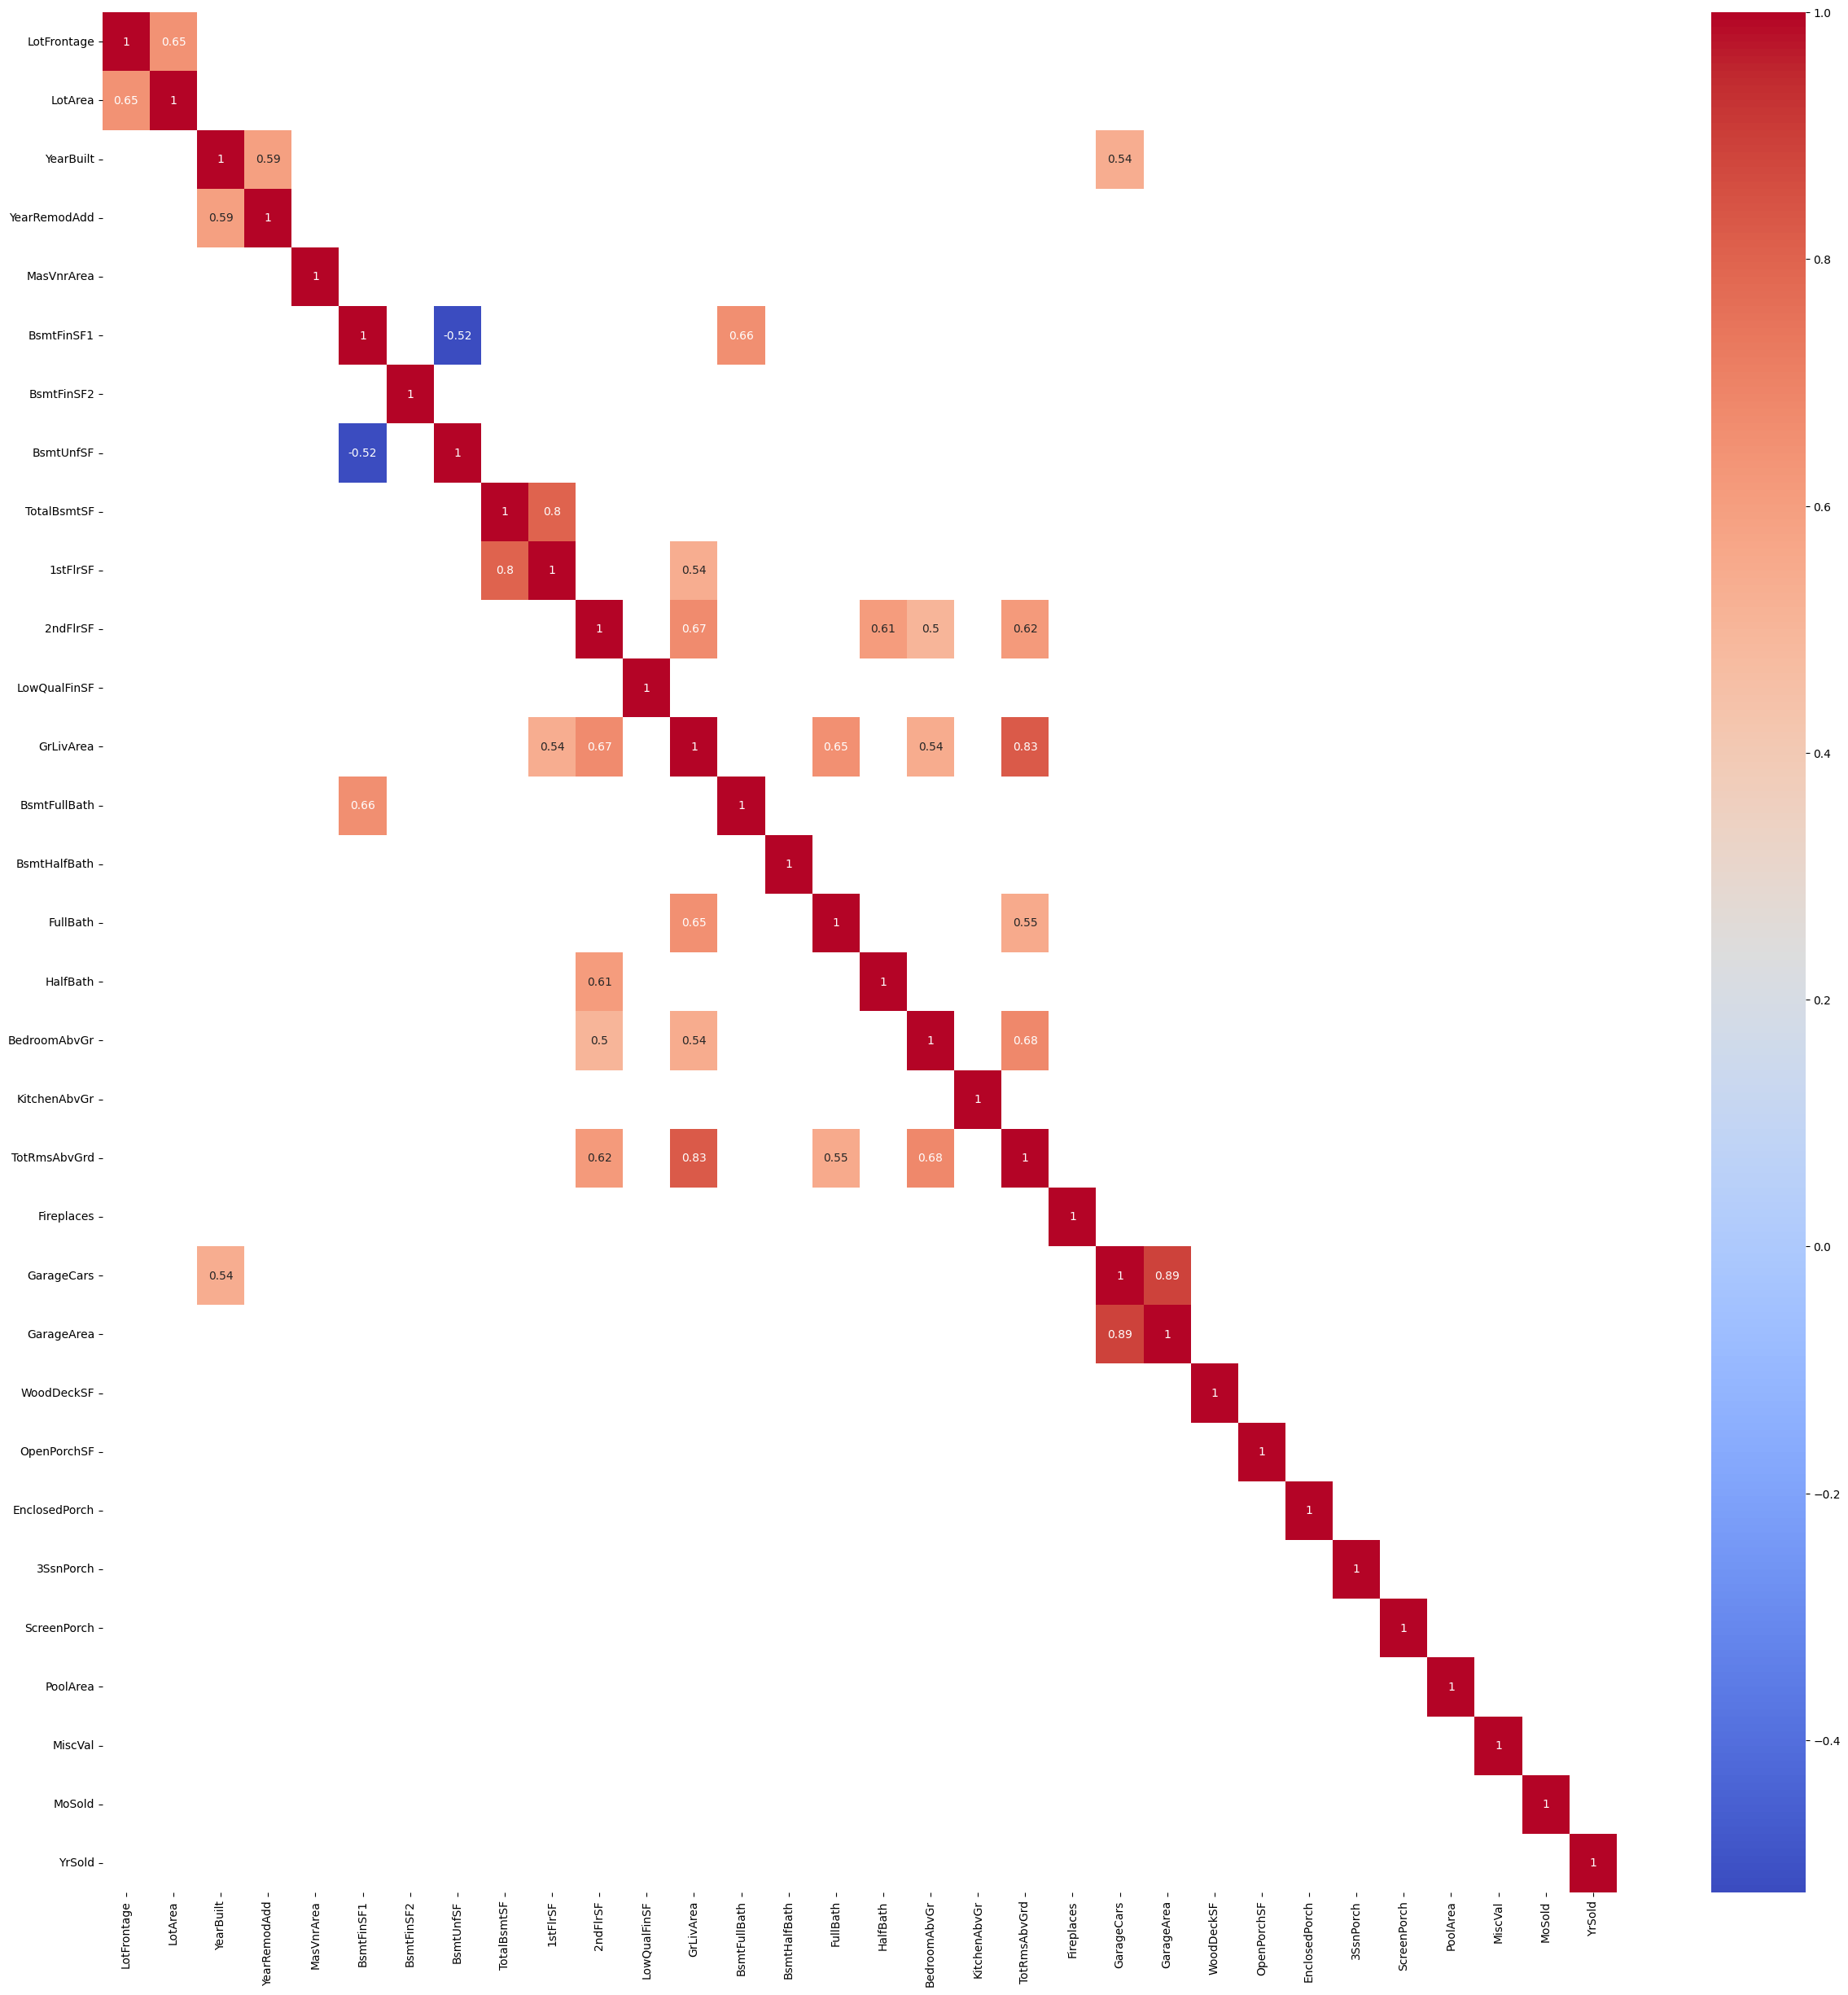

In [130]:
#Variáveis lineares
threshold_corr=0.5
corr_pearson = df[linear_variables].corr(method='pearson')
corr_pearson = corr_pearson[corr_pearson.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_pearson,annot=True,cmap='coolwarm')
plt.show()

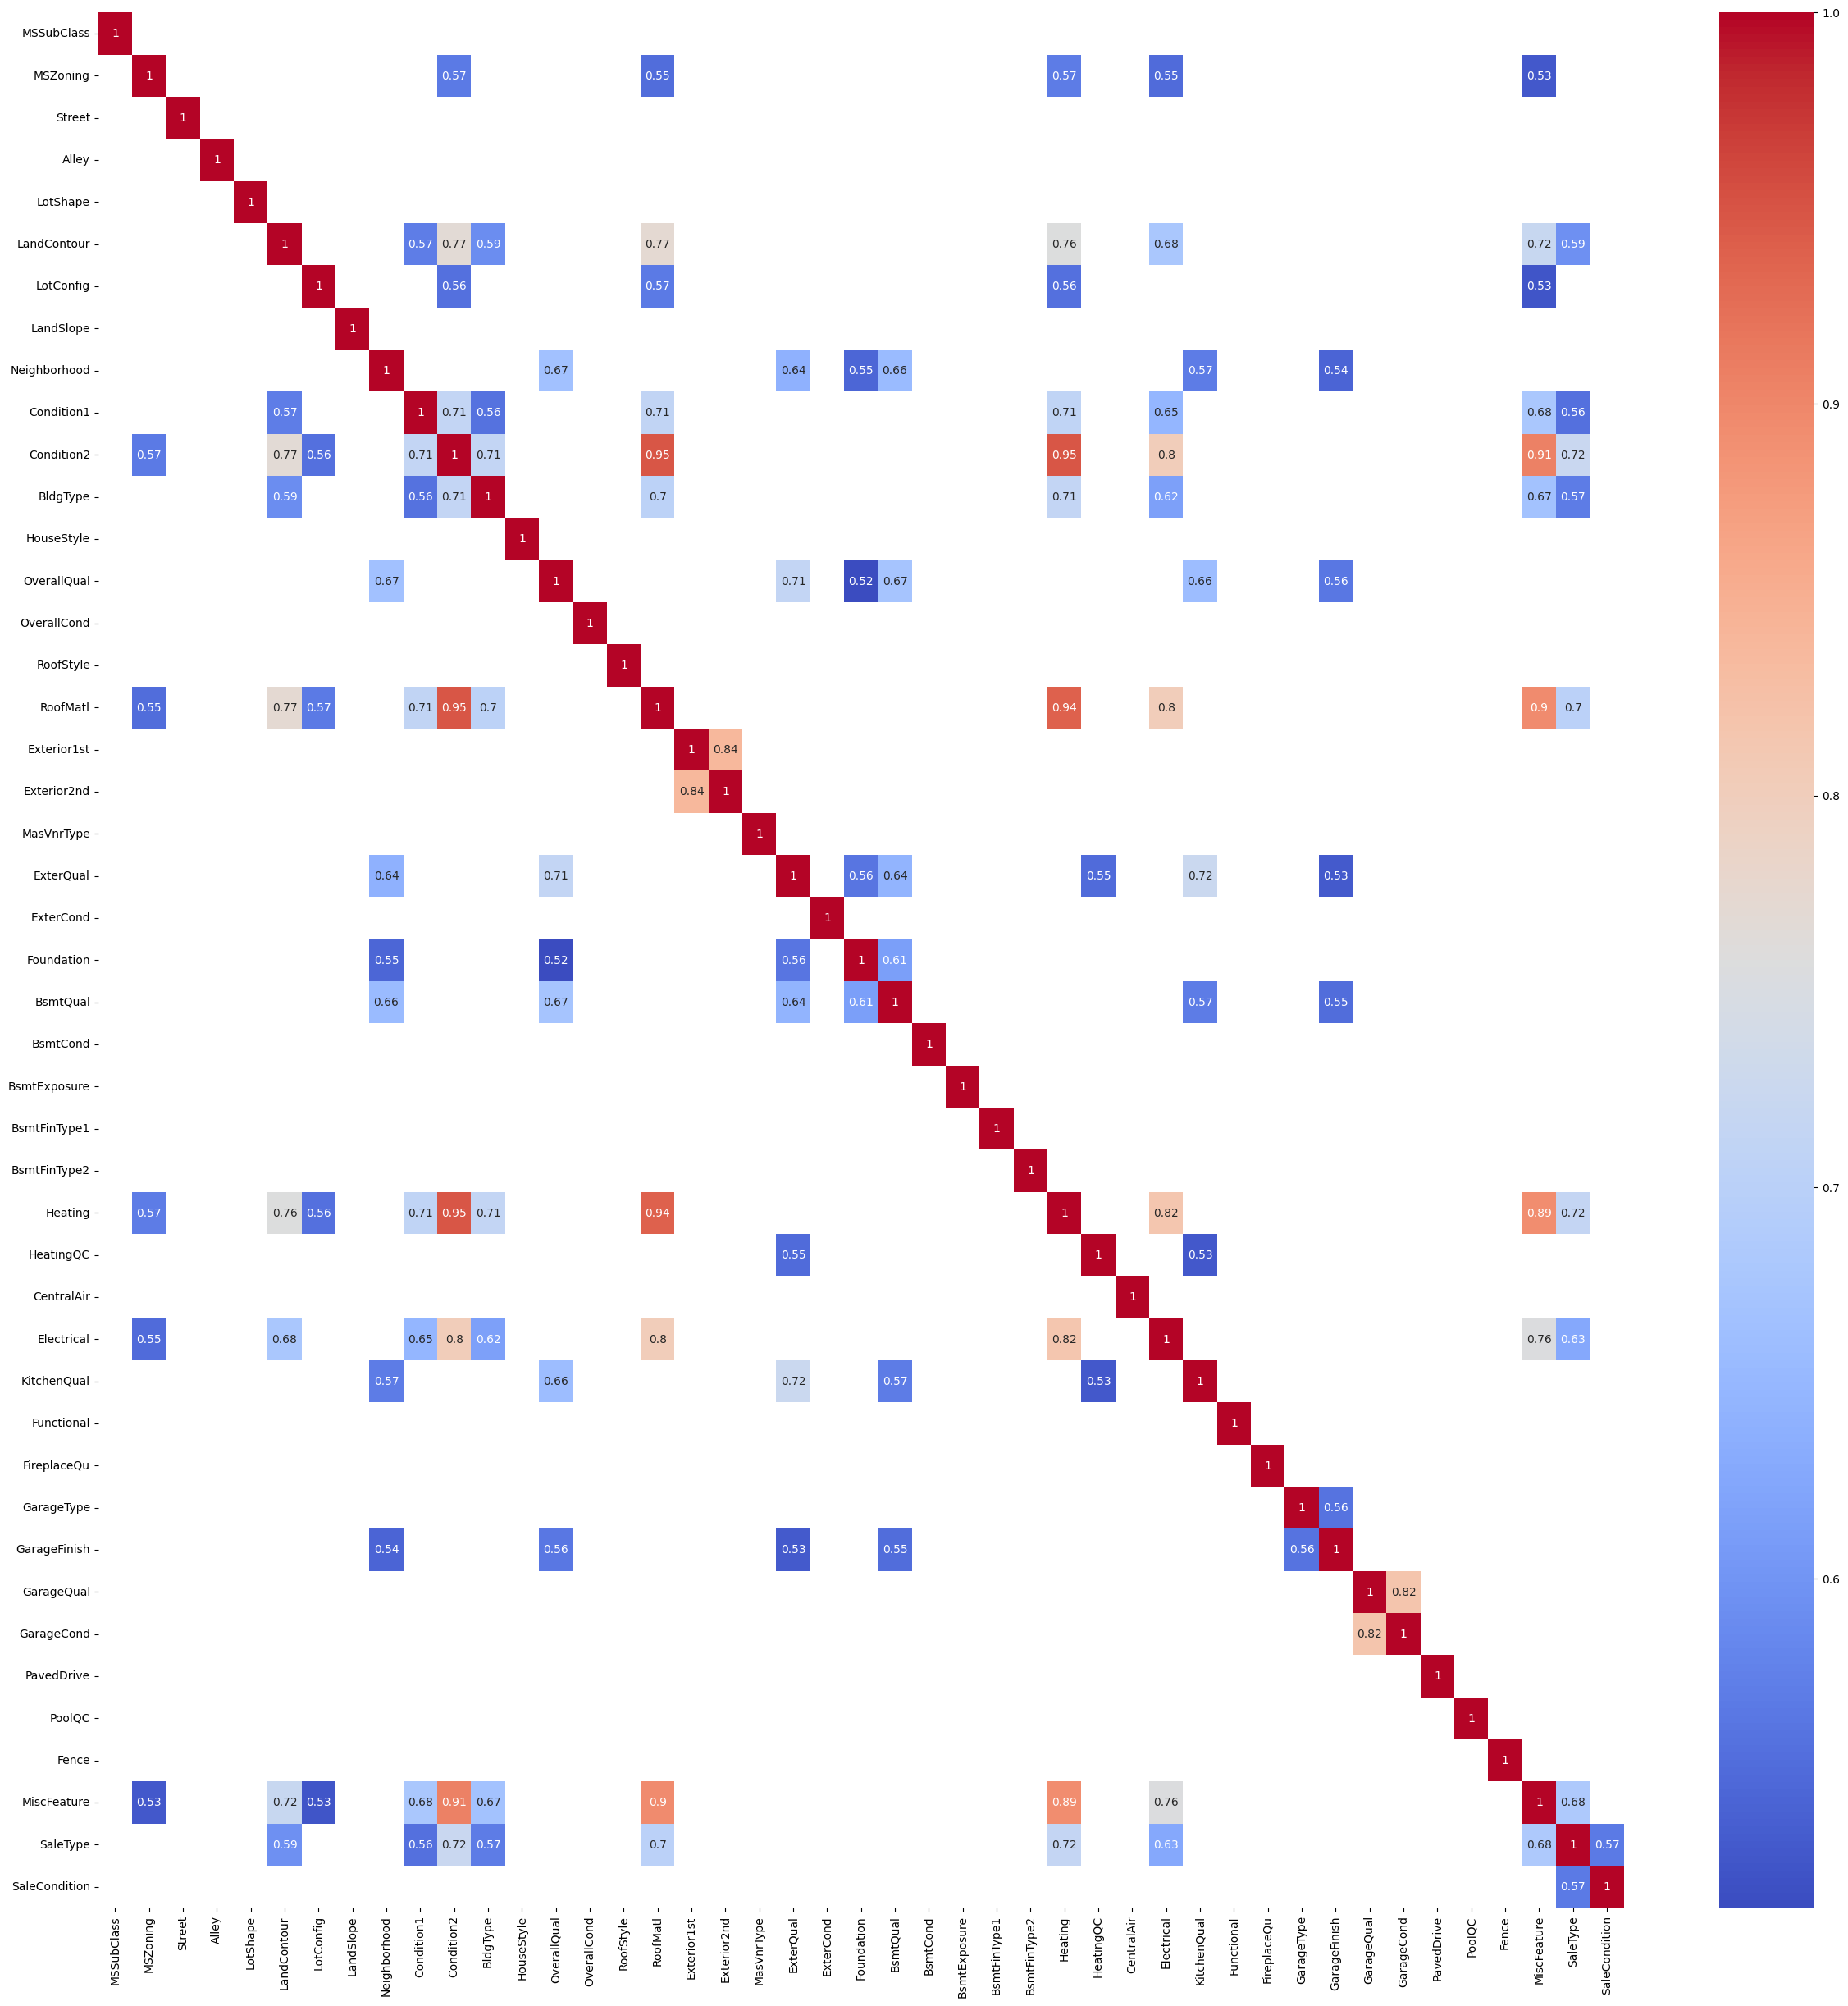

In [131]:
#Variáveis ordinal e categoricas
corr_spearman = df[ordinal_categorical_variables].corr(method='spearman')
corr_spearman= corr_spearman[corr_spearman.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_spearman,annot=True,cmap='coolwarm')
plt.show()

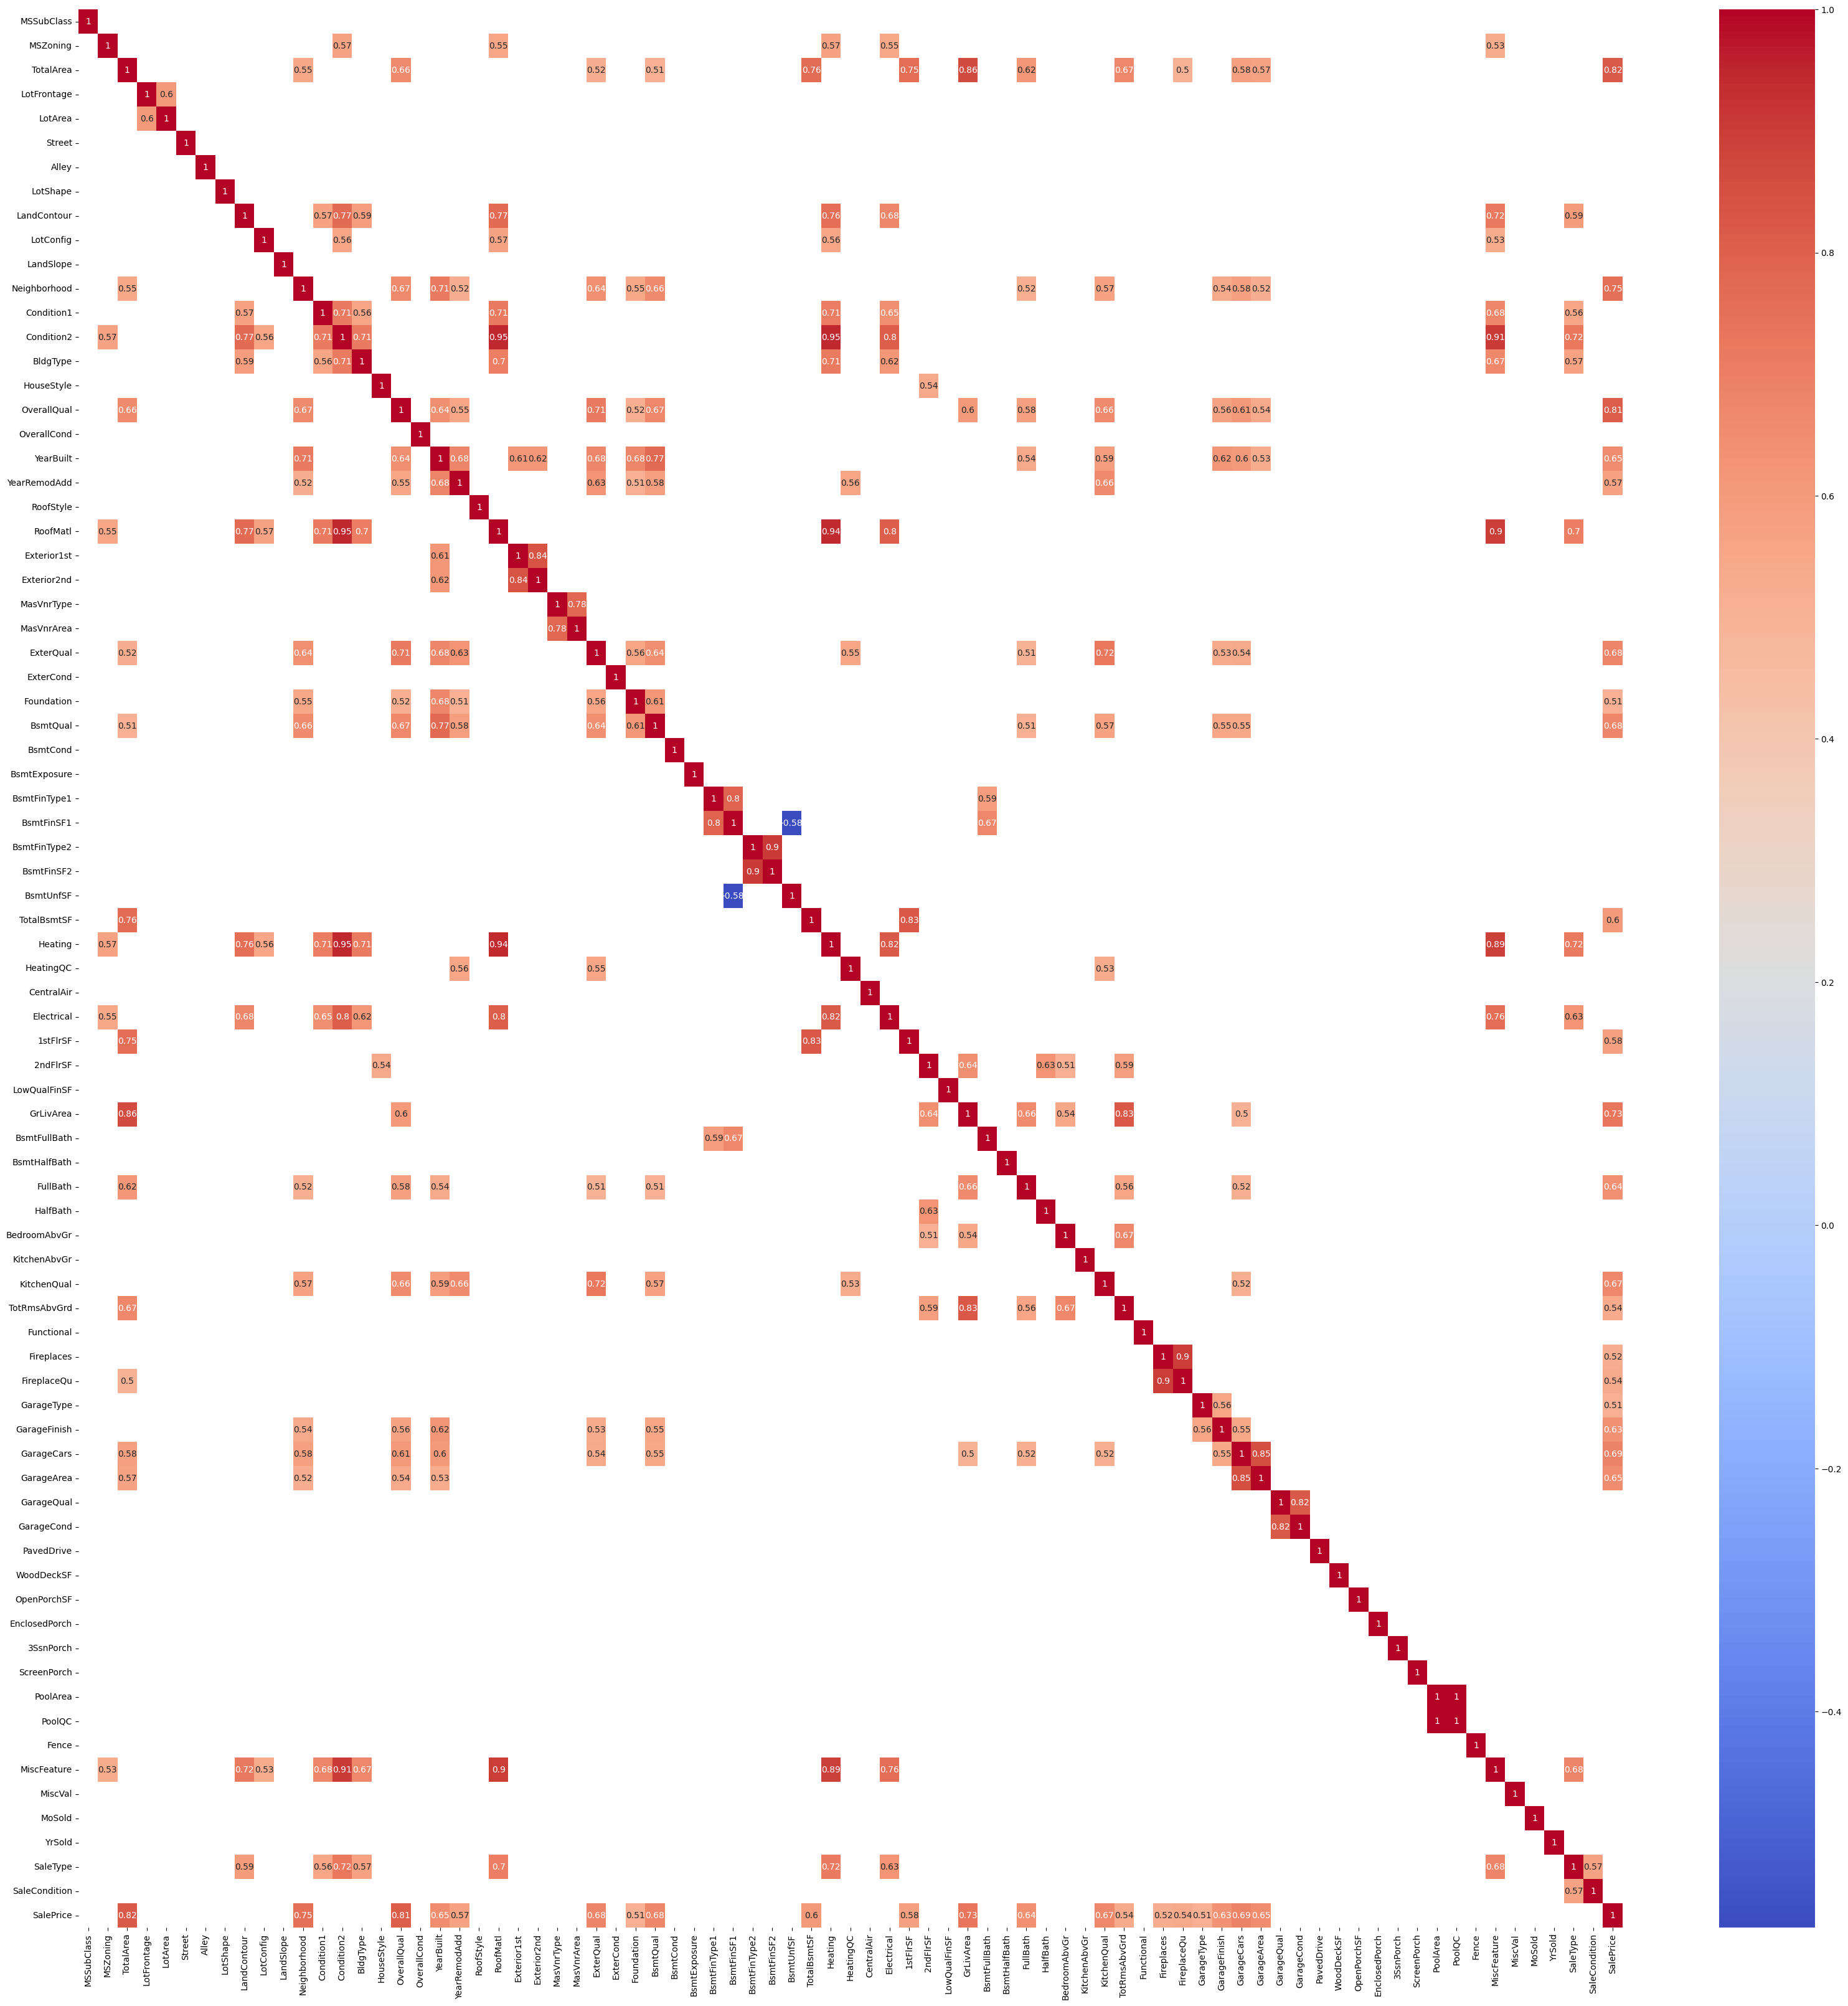

In [132]:
#Todas as variaveis
corr_spearman = df.corr(method='spearman')
corr_spearman= corr_spearman[corr_spearman.abs()> threshold_corr]
plt.figure(figsize=(40, 40))
sn.heatmap(corr_spearman,annot=True,cmap='coolwarm')
plt.show()

Importância

In [133]:
#Random Forest importance

rf = RandomForestRegressor()
x = df.drop(columns=['SalePrice'])
y = df['SalePrice']
rf.fit(x,y)
importances = np.round(rf.feature_importances_,4)

feature_names = df.columns
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df

,Feature,Importance
0,OverallQual,0.4505
1,TotalArea,0.3048
2,Neighborhood,0.0585
3,CentralAir,0.0135
4,GrLivArea,0.0130
...,...,...
73,3SsnPorch,0.0001
74,Street,0.0001
75,MiscVal,0.0001
76,LowQualFinSF,0.0001


In [134]:
#Permutation importance

results = permutation_importance(rf,x,y,scoring='neg_mean_squared_error')
importances = results.importances_mean
#Normalizar e arredondar valores
importances = np.round((importances / importances.sum()),4)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df


,Feature,Importance
0,TotalArea,0.4545
1,OverallQual,0.2889
2,Neighborhood,0.0888
3,YearRemodAdd,0.0148
4,GrLivArea,0.0121
...,...,...
73,3SsnPorch,0.0001
74,Street,0.0000
75,PoolArea,0.0000
76,LowQualFinSF,0.0000


# Outlier Detection

Outlier detection

C:\Users\catar\AppData\Local\Temp\ipykernel_15640\2771433882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mahalanobis_Distance'] = distances


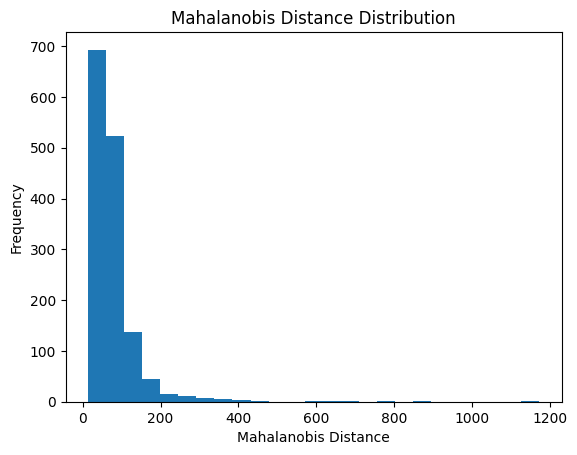

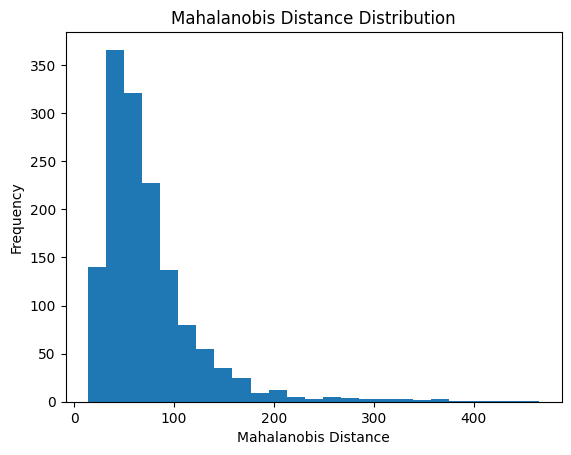

In [135]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
cov_model = EmpiricalCovariance().fit(df_scaled)
distances = cov_model.mahalanobis(df_scaled)

#Acrescentar temporáriamente uma coluna com as mahanalobis distances
df['Mahalanobis_Distance'] = distances

plt.hist(df['Mahalanobis_Distance'], bins=25)
plt.title('Mahalanobis Distance Distribution')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.show()

df = df[df['Mahalanobis_Distance'] < 500]

plt.hist(df['Mahalanobis_Distance'], bins=25)
plt.title('Mahalanobis Distance Distribution')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.show()

df = df.drop(columns=['Mahalanobis_Distance'])

# Implementação de Bayesian optimization para hyperparâmetros

Definir K-Fold para avaliação

In [136]:
def KFold_metrics(df,model,k,metric):
    x = np.array(df.drop(columns=['SalePrice']))
    y = np.array(df['SalePrice'])
    kf = KFold(n_splits=k)
    PRED = None
    TRUTH = None
    for Train_Index, Test_Index in kf.split(x,y):
        X_Train,X_Test = x[Train_Index],x[Test_Index]
        Y_Train,Y_Test = y[Train_Index],y[Test_Index]
        model.fit(X_Train,Y_Train)
        prediction = model.predict(X_Test)
        if (PRED is None or TRUTH is None):
            PRED = prediction
            TRUTH = Y_Test
        else:
            PRED = np.hstack((PRED,prediction))
            TRUTH = np.hstack((TRUTH,Y_Test))
    return metric(TRUTH,PRED)

Bayesian optimization

In [629]:
n_call = 1
def objective_function(params):
    global n_call
    n_features_to_select, n_estimators, max_depth, learning_rate, min_child_weight, reg_alpha, reg_lambda, gamma, subsample, colsample_bytree = params
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42  
    )
    print(n_call)
    n_call += 1
    pipeline = Pipeline([('rfe', RFE(n_features_to_select=n_features_to_select,estimator=model)),('model',model)])
    #Para sem outliers por agora
    return KFold_metrics(df,pipeline,10,root_mean_squared_error)

search_space = [
    Integer(10, 78, name='rfe__n_features_to_select'),
    Integer(100, 1000, name='xgb__n_estimators'),
    Integer(3, 10, name='xgb__max_depth'),
    Real(0.01, 0.3, name='xgb__learning_rate', prior='log-uniform'),
    Integer(1, 10, name='xgb__min_child_weight'),
    Real(1e-5, 1, name='xgb__reg_alpha', prior='log-uniform'),
    Real(1e-5, 10, name='xgb__reg_lambda', prior='log-uniform'),
    Real(0, 5, name='xgb__gamma'),
    Real(0.5, 1, name='xgb__subsample'),
    Real(0.3, 1, name='xgb__colsample_bytree')
]

result = gp_minimize(
    func=objective_function, 
    dimensions=search_space,
    n_calls=100,   
    random_state=42
)

print("Best parameters found: ", result.x)  
print("Best score: ", result.fun)  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Best parameters found:  [54, 657, 3, 0.031822302998949066, 2, 1e-05, 1e-05, 0.0, 0.5, 0.3]
Best score:  0.11076380069916973


# Treino e teste

Modelos

In [137]:
#XGB com RFE e hyperparameters
#Best parameters found:  [78, 1000, 3, 0.025305151973287355, 1, 1e-05, 1e-05, 0.0, 0.5, 0.3]
xgb = XGBRegressor(random_state=42,n_estimators=1000,learning_rate=0.025305151973287355,max_depth=3,min_child_weight=1,reg_alpha=1e-05,reg_lambda=1e-05,gamma = 0, subsample=0.5,colsample_bytree=0.3)
pipeline_xgb = Pipeline([('rfe',RFE(n_features_to_select=77,estimator=xgb)),('xgb',xgb)])
print(KFold_metrics(df,pipeline_xgb,10,root_mean_squared_error))

import warnings
from sklearn.exceptions import ConvergenceWarning
#Lasso Regression com RFE e hyperparameters
#Best parameters found:  [78, 0.00023547089218786422]
warnings.filterwarnings("ignore", category=ConvergenceWarning)
lasso = Lasso(alpha=0.00023547089218786422,max_iter=5000, random_state=42)
pipeline_lasso = Pipeline([('scaler', RobustScaler()),('rfe',RFE(n_features_to_select=77,estimator=lasso)),('lasso',lasso)])
print(KFold_metrics(df,pipeline_lasso,10,root_mean_squared_error))

#LinearSVR Com RFE e hyperparameters
#Best parameters found:  [32, 863.8041923019508, 0.05530926071486477]
linearsvr = LinearSVR(C=863.8041923019508, epsilon=0.05530926071486477)
pipeline_svr = Pipeline([('scaler', StandardScaler()),('rfe',RFE(n_features_to_select=32,estimator=linearsvr)),('svr',linearsvr)])
#print(KFold_metrics(df,pipeline_svr,10,root_mean_squared_error))

#KNN com RFE e hyperparameters
#Best parameters found:  [10, 6]
knn_regressor = KNeighborsRegressor(n_neighbors=6)
pipeline_knn = Pipeline([('scaler', StandardScaler()),('rfe',RFE(n_features_to_select=10,estimator=lasso)),('knn',knn_regressor)])
#print(KFold_metrics(df,pipeline_knn,10,root_mean_squared_error))

#Modelo ensemble sem tuning no ridge final 
pipeline_ensemble = StackingRegressor(estimators=[('xgb',pipeline_xgb),('lasso',pipeline_lasso)])
print(KFold_metrics(df,pipeline_ensemble,10,root_mean_squared_error))

#A bater
#0.11101102830126922
#0.11490766029826949
#0.10857799935318702

0.11342254360680445
0.11483331546047366
0.1096968847631346


# Submissão para competição

In [58]:
df_test = pd.read_csv("C:\\Users\\catar\\Desktop\\Projetos AI\\ML_houseprices\\test.csv")
Ids = df_test['Id']
df_test = df_test.drop(columns=['Id','Utilities','GarageYrBlt'])

#Ordinal encoding
columns_to_encode = ['Street', 'Alley', 'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

categories_list = [['Grvl', 'Pave'],
                   ['Grvl', 'Pave'],
                   ['IR3', 'IR2', 'IR1', 'Reg'],
                   ['Sev', 'Mod', 'Gtl'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['No', 'Mn', 'Av', 'Gd'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Unf', 'RFn', 'Fin'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'P', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

ordinal_encoder = OrdinalEncoder(categories= categories_list,
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1,
                                 dtype=np.int64)
#Converter para objeto para garantir compatabilidade
df_test[columns_to_encode] = df_test[columns_to_encode].astype(object)
df_test[columns_to_encode] = ordinal_encoder.fit_transform(df_test[columns_to_encode])

#Target encoding (usando os valores globais para treino)
columns_to_encode = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
           'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
           'SaleType', 'SaleCondition']
df_test['SaleType'] = df_test['SaleType'].fillna('Oth')
i = 0
for col in columns_to_encode:
    df_test[col] = df_test[col].fillna('Missing')
    valores_globais = medias_groupby_col[i]
    df_test[col] = df_test[col].map(valores_globais)
    df_test[col] = df_test[col].astype(np.float64)
    i+=1

df_test['TotalArea']= df_test['TotalBsmtSF']+ df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test.insert(2, 'TotalArea', df_test.pop('TotalArea'))


#Preencher valores NULL
#Sub pela média do bairro
df_test['LotFrontage'] = df_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_test['MSZoning'] = df_test.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.median()))
df_test['Exterior1st'] = df_test.groupby('Neighborhood')['Exterior1st'].transform(lambda x: x.fillna(x.median()))
df_test['Exterior2nd'] = df_test.groupby('Neighborhood')['Exterior2nd'].transform(lambda x: x.fillna(x.median()))

#Sub para valores em que n existe garagem
basement_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','GarageCars','GarageArea']
df_test['TotalArea']= df_test['TotalArea'].fillna(df_test['1stFlrSF'] + df_test['2ndFlrSF'])
df_test[basement_columns] = df_test[basement_columns].fillna(0)

#Finalizar
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)


#Tranformação de valores
for feature in skew_feature_transform:
    df_test[feature] = boxcox1p(df_test[feature],lamb)
    
#Treino e prediction
x = np.array(df.drop(columns=['SalePrice']))
y = np.array(df['SalePrice'])
pipeline_ensemble.fit(x,y)

predict = pipeline_ensemble.predict(np.array(df_test))
predict = np.expm1(predict)
output = {
    'Id': Ids,
    'SalePrice': predict
}
df_output = pd.DataFrame(output)
df_output.to_csv('my_submission.csv', index=False)
df_output
#Improve feature selection

,Id,SalePrice
0,1461,117191.823180
1,1462,154625.446181
2,1463,182954.519113
3,1464,196116.102613
4,1465,188195.233214
...,...,...
1454,2915,87626.973985
1455,2916,86044.561585
1456,2917,162596.927630
1457,2918,118370.383340
